In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skl
import torch.linalg as lin

## LQR with deterministic dynamics

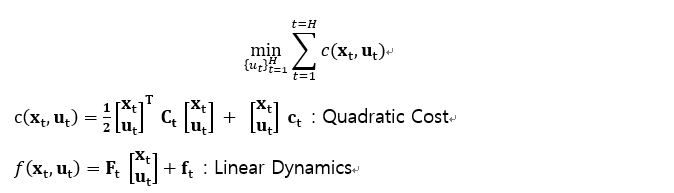

위에 기술된 최적화 문제는

환경 $f(\textbf{x}_t, \textbf{u}_t)$ 가 선형(Linear)이고, Cost function이 Quadratic 형태입니다. LQR 수업에서 배웠던 수식과 동일하게 구성이 되어 있습니다.

$\textbf{x}_t$는 시점 $t$에서 시스템의 상태를 나타냅니다. $\textbf{u}_t$는 시점 $t$에서의 행동, 혹은 시스템에 넣어주는 저희의 action을 표현하는 벡터입니다. $\textbf{C}_t\ 와\  \textbf{c}_t$ 는 각각 cost fucntion에서 2차항과 1차항의 계수입니다. $\textbf{F}_t \ 와 \ \textbf{f}_t$ 는 Linear Dynamics의 계수들입니다.

위의 수식에서는 시간에 따른 가변성이 있을 수도 있어 다음과 같이 $t$를 첨자로 두었으나, 저희가 구현할 문제에 대해서는 시간에 invariant하다고 가정을 할 것입니다.

다음과 같은 문제를 효율적으로 풀 수 있는 기법 중 하나인 LQR을 구현해볼 것입니다.

## optimization 문제 기본 setting

우선 LQR 알고리즘을 구현하기 이전에 문제의 기본 세팅을 하겠습니다. 
state, action의 dimension 그리고 cost function, linear Dynamics의 계수를 세팅하겠습니다.

(각 계수들은 미리 정해두었습니다. 위의 주석은 계수에 대한 기본 설명, 행렬의 크기입니다.)

In [3]:
state_dim = 2 # state dimension
action_dim = 2 # action dimension

T = 10

# Cost function's coefficient of second order term 
# matrix shape [(state_dim + action_dim) * (state_dim + action_dim)]
C = torch.eye(n=(state_dim + action_dim)) / 10

# Cost function's coefficient of first order term
# matrix shape [(state_dim + action_dim), 1)]
c = torch.rand(size=(state_dim + action_dim, 1))

# Linear Dynamics's coefficient of first order term
# matrix shape [state_dim * (state_dim + action_dim)]
F = torch.rand(size=(state_dim, state_dim + action_dim)) / 10

# Linear Dynamics's coefficient of constant term
# matrix shape[(state_dim, 1)]
f = torch.zeros(size=(state_dim, 1))

# dictionary of K
Large_K = dict()
small_k = dict()

# dictionary of V
Large_V = dict()
small_v = dict()

# dictionary of Q
Large_Q = dict()
small_q = dict()

## 시점 T에서 LQR을 통한 최적 행동의 계수 K 구하기

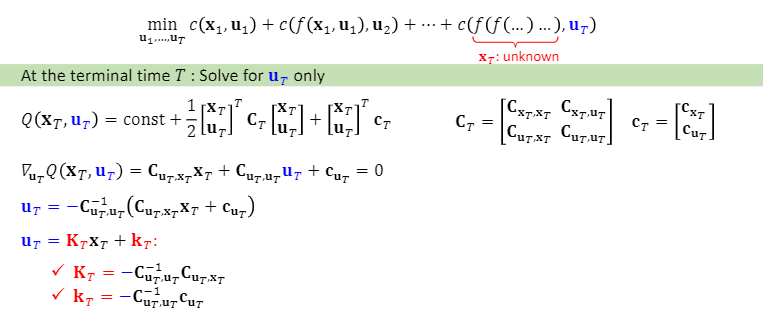

강의에서 보셨던 것처럼 $\textbf{K}_T \ 와 \ \textbf{k}_T$ 를 구하고, 그 값을 바탕으로 시점 $T$에서의 optimal한 action, $\textbf{u}_T$ 를 구할 수 있습니다.

$\textbf{u}_T$의 계산을 위해 필요한 계수를 구하고, 그 값들을 dictionary에 저장하도록 하겠습니다

(추후에 forward 과정을 위해서 필요하기 때문!!!!)

In [4]:
K_T =  - torch.matmul(torch.linalg.inv(C[:action_dim, :action_dim]), C[state_dim:, :state_dim])
k_T = - torch.matmul(torch.linalg.inv(C[state_dim:,  state_dim:]), c[state_dim:, :])

In [5]:
print("K_T:  ", K_T)
print("k_T:  ", k_T)

Large_K[T] = K_T
small_k[T] = k_T

K_T:   tensor([[-0., -0.],
        [-0., -0.]])
k_T:   tensor([[-1.5028],
        [-2.2779]])


### 함수화

In [6]:
def calculate_K(Q, q, state_dim, action_dim):
    K_t =  - torch.matmul(torch.linalg.inv(Q[:action_dim, :action_dim]), Q[state_dim:, :state_dim])
    k_t = - torch.matmul(torch.linalg.inv(Q[state_dim:,  state_dim:]), q[state_dim:, :])
    
    return K_t, k_t

## 시점 T에서의 최적 행동을 바탕으로 cost 계산

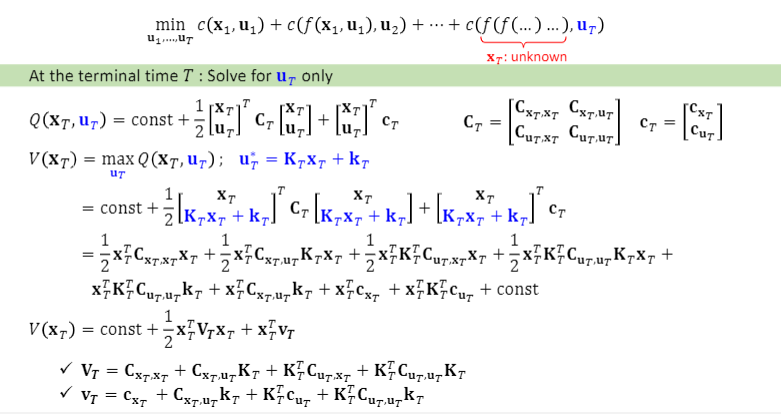

앞서 구한 action $\textbf{u}_T$를 objective의 cost function에 대입하여 $Q((\textbf{x}_t, \textbf{u}_t)$를 $V(\textbf{x}_t)$로 상태변수 $\textbf{x}_t$ 만을 인자로 가지는 함수로 바꿀 수 있습니다.

In [7]:
V_T = C[:state_dim, state_dim] + torch.matmul(C[:state_dim, state_dim:], Large_K[T]) + torch.matmul(Large_K[T].T, C[state_dim:, :state_dim]) + torch.matmul(torch.matmul(Large_K[T].T, C[state_dim:, state_dim:]), Large_K[T])
v_T = c[:state_dim, :] + torch.matmul(C[:state_dim, state_dim:], small_k[T]) + torch.matmul(Large_K[T].T, c[state_dim:, :]) + torch.matmul(torch.matmul(Large_K[T].T, C[state_dim:, state_dim:]), small_k[T])

In [8]:
print("V_T:  ", V_T)
print("v_T:  ", v_T)

Large_V[T] = V_T
small_v[T] = v_T

V_T:   tensor([[0., 0.],
        [0., 0.]])
v_T:   tensor([[0.2757],
        [0.6203]])


### 함수화

In [9]:
def calculate_V(C, c, state_dim, action_dim, K_t, small_k):
    V_t = C[:state_dim, :state_dim] + torch.matmul(C[:state_dim, state_dim:], K_t) + torch.matmul(K_t.T, C[state_dim:, :state_dim]) + torch.matmul(torch.matmul(K_t.T, C[state_dim:, state_dim:]), K_t)
    v_t = c[:state_dim, :] + torch.matmul(C[:state_dim, state_dim:], small_k) + torch.matmul(K_t.T, c[state_dim:, :]) + torch.matmul(torch.matmul(K_t.T, C[state_dim:, state_dim:]), small_k)
    
    return V_t, v_t

## 시점 T-1 에서의 cost를 $\textbf{x}_{t-1}, \ \textbf{u}_{t-1}$ 로 표현

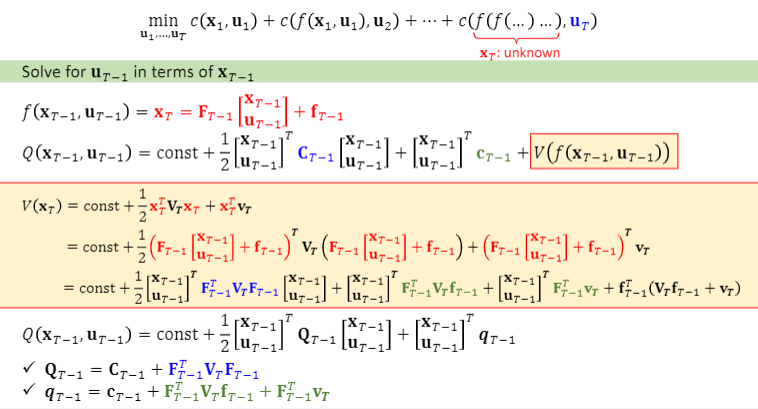

C와 F는 time-invariant 한 coefficient이고, $\textbf{V}_T\ 와 \ \textbf{v}_T $는 이전 셀에서 구했습니다.

In [10]:
Q_t = C + torch.matmul(torch.matmul(F.T, Large_V[T]), F)
q_t = c + torch.matmul(torch.matmul(F.T, Large_V[T]), f) + torch.matmul(F.T, small_v[T])

In [11]:
Large_Q[T-1] = Q_t
small_q[T-1] = q_t

### 함수화

In [12]:
def calculate_Q(C, c, Large_V, small_v, F, f):
    Q_t = C + torch.matmul(torch.matmul(F.T, Large_V), F)
    q_t = c + torch.matmul(torch.matmul(F.T, Large_V), f) + torch.matmul(F.T, small_v)
    
    return Q_t, q_t

## Backword recursion 시점 T=0 까지 진행

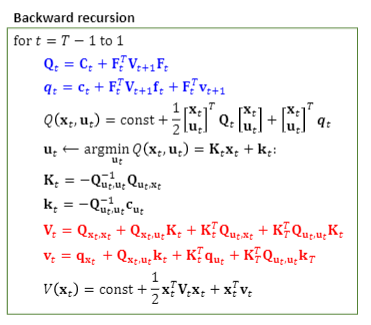

위의 3가지 과정을 시점 T-1, T-2, ... , 1 까지 반복하여 coefficient(V, K, Q)를 구하고 저장합니다. 

In [13]:
T = 10

state_dim = 2
action_dim = 2

C = torch.rand(size=(state_dim + action_dim, state_dim + action_dim))

# invertible check about matrix C
while True:
    if (torch.matrix_rank(C) == state_dim + action_dim) and (torch.matrix_rank(C[:state_dim, :state_dim]) == state_dim) and (torch.matrix_rank(C[state_dim:, state_dim:]) == action_dim):
        break
    else:
        C = torch.rand(size=(state_dim + action_dim, state_dim + action_dim))

c = torch.rand(size=(state_dim + action_dim, 1)) 
F = torch.rand(size=(state_dim, state_dim + action_dim)) / 10
f = torch.rand(size=(state_dim, 1))

K_t, k_t = calculate_K(C, c, state_dim, action_dim)

Large_K[T] = K_t
small_k[T] = k_t

V_t, v_t = calculate_V(C, c, state_dim, action_dim, K_t, k_t)
Large_V[T] = V_t
small_v[T] = v_t

for time in range(T-1, 0, -1):
    
    # calculate Q
    Q_t, q_t = calculate_Q(C, c, V_t, v_t, F, f)
    Large_Q[time] = Q_t
    small_q[time] = q_t
    
    K_t, k_t = calculate_K(Q_t, q_t, state_dim, action_dim)
    Large_K[time] = K_t
    small_k[time] = k_t
    
    V_t, v_t = calculate_V(C, c, state_dim, action_dim, K_t, k_t)
    Large_V[time] = V_t
    small_v[time] = v_t

c:\users\hae1\anaconda3\envs\mpc\lib\site-packages\ipykernel_launcher.py:10: UserWarning: torch.matrix_rank is deprecated in favor of torch.linalg.matrix_rankand will be removed in a future PyTorch release. The parameter 'symmetric' was renamed in torch.linalg.matrix_rank to 'hermitian'. (Triggered internally at  ..\aten\src\ATen\native\LinearAlgebra.cpp:438.)
  # Remove the CWD from sys.path while we load stuff.


### 함수화

In [176]:
def backward_recursion(state_dim, action_dim, C, c, F, f, T):
    
    # dictionary of K
    Large_K = dict()
    small_k = dict()

    # dictionary of V
    Large_V = dict()
    small_v = dict()

    # dictionary of Q
    Large_Q = dict()
    small_q = dict()
    
    K_t, k_t = calculate_K(C, c, state_dim, action_dim)

    Large_K[T] = K_t
    small_k[T] = k_t

    V_t, v_t = calculate_V(C, c, state_dim, action_dim, K_t, k_t)
    Large_V[T] = V_t
    small_v[T] = v_t

    for time in range(T-1, 0, -1):

        # calculate Q
        Q_t, q_t = calculate_Q(C, c, V_t, v_t, F, f)
        Large_Q[time] = Q_t
        small_q[time] = q_t

        K_t, k_t = calculate_K(Q_t, q_t, state_dim, action_dim)
        Large_K[time] = K_t
        small_k[time] = k_t

        V_t, v_t = calculate_V(C, c, state_dim, action_dim, K_t, k_t)
        Large_V[time] = V_t
        small_v[time] = v_t
        
    return Large_Q, small_q, Large_K, small_k, Large_V, small_v

In [177]:
backward_recursion(state_dim, action_dim, C, c, F, f, T)

({19: tensor([[18.1009,  0.4780, -9.0000, -0.0929],
          [ 0.4780, 18.1192, -0.4383, -9.0000],
          [-9.0000, -0.4383, 10.0100,  0.0000],
          [-0.0929, -9.0000,  0.0000, 10.0100]]),
  18: tensor([[ 1.8103e+01,  4.7817e-01, -9.0022e+00, -9.2918e-02],
          [ 4.7817e-01,  1.8121e+01, -4.3839e-01, -9.0022e+00],
          [-9.0022e+00, -4.3839e-01,  1.0012e+01,  1.5526e-05],
          [-9.2918e-02, -9.0022e+00,  1.5526e-05,  1.0012e+01]]),
  17: tensor([[ 1.8103e+01,  4.7817e-01, -9.0022e+00, -9.2918e-02],
          [ 4.7817e-01,  1.8121e+01, -4.3839e-01, -9.0022e+00],
          [-9.0022e+00, -4.3839e-01,  1.0012e+01,  1.5517e-05],
          [-9.2918e-02, -9.0022e+00,  1.5517e-05,  1.0012e+01]]),
  16: tensor([[ 1.8103e+01,  4.7817e-01, -9.0022e+00, -9.2918e-02],
          [ 4.7817e-01,  1.8121e+01, -4.3839e-01, -9.0022e+00],
          [-9.0022e+00, -4.3839e-01,  1.0012e+01,  1.5517e-05],
          [-9.2918e-02, -9.0022e+00,  1.5517e-05,  1.0012e+01]]),
  15: tensor([[ 

## forward recursion 진행


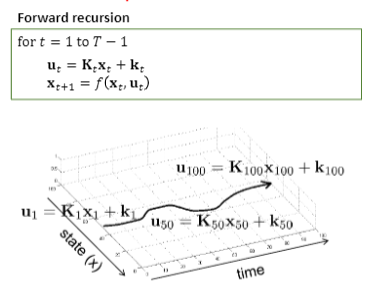

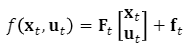

In [178]:
x_dict = dict()
u_dict = dict()

x0 = torch.randn(size=(state_dim, 1))
x_dict[1] = x0

for time in range(1, T):
    
    u_t = torch.matmul(Large_K[time], x_dict[time]) + small_k[time]
    u_dict[time] = u_t
    
    next_x = torch.matmul(F, torch.cat([x_dict[time], u_t], dim=0)) + f
    x_dict[time+1] = next_x

### 함수화

In [179]:
def forward_recursion(x0, Large_K, small_k, F, f, T):
    x_dict = dict()
    u_dict = dict()
    
    x_dict[1] = x0

    for time in range(1, T):

        u_t = torch.matmul(Large_K[time], x_dict[time]) + small_k[time]
        u_dict[time] = u_t

        next_x = torch.matmul(F, torch.cat([x_dict[time], u_t], dim=0)) + f
        x_dict[time+1] = next_x
        
    return x_dict, u_dict

In [209]:
x_dict, u_dict = forward_recursion(x0, Large_K, small_k, F, f, T)

xs = dict()
for state in range(state_dim):
    xs[state] = []
us = dict()
for action in range(action_dim):
    us[action] = []
    
    
for key, item in x_dict.items():
    print('x at time ' + str(key) + ': ', item )
    for state in range(state_dim):
        xs[state].append(float(item[state]))

for key, item in u_dict.items():
    print('u at time ' + str(key) + ': ', item )
    for action in range(action_dim):
        us[action].append(float(item[action]))

x at time 1:  tensor([[50.],
        [50.]])
x at time 2:  tensor([[-2.6901],
        [-1.6621]])
x at time 3:  tensor([[ 0.1956],
        [-0.0056]])
x at time 4:  tensor([[-0.0205],
        [ 0.0121]])
x at time 5:  tensor([[ 0.0027],
        [-0.0023]])
x at time 6:  tensor([[-0.0004],
        [ 0.0004]])
x at time 7:  tensor([[ 5.9438e-05],
        [-5.8209e-05]])
x at time 8:  tensor([[-9.0163e-06],
        [ 8.9025e-06]])
x at time 9:  tensor([[ 1.3713e-06],
        [-1.3571e-06]])
x at time 10:  tensor([[-2.0872e-07],
        [ 2.0670e-07]])
x at time 11:  tensor([[ 3.1775e-08],
        [-3.1474e-08]])
x at time 12:  tensor([[-4.8376e-09],
        [ 4.7921e-09]])
x at time 13:  tensor([[ 7.3654e-10],
        [-7.2960e-10]])
x at time 14:  tensor([[-1.1213e-10],
        [ 1.1104e-10]])
x at time 15:  tensor([[ 1.7053e-11],
        [-1.6857e-11]])
x at time 16:  tensor([[-2.5712e-12],
        [ 2.5214e-12]])
x at time 17:  tensor([[ 3.6685e-13],
        [-3.4931e-13]])
x at time 1

# Implementation: Data Center temperature control

비즈니스 전체 영역에서의 언택트 환경이 확장됨에 따라 데이터 사용량이 급증하고 전세계적으로 대용량 데이터 관리를 위한 하이퍼스케일 데이터센터 건립이 증가하고 있습니다.

데이터의 용량과 속도가 빠르게 증가함에 따라 서버의 처리량도 증가하고 온도 또한 높아집니다.
서버의 온도 상승은 고장 및 성능 하락의 원인이 돼 이를 냉각시키는 과정이 필요하며 데이터센터 에너지 소비의 35% 이상이 서버 냉각에서 발생합니다.

그래서 데이터 센터의 온도 제어를 LQR을 통해서 최적의 온도 trajectory와 action sequence를 구해보고자 합니다.

편의상 데이터 센터의 온도는 선형적인 시스템에 의해서 가동이 되고 있다고 가정하고,
최적의 온도 또한 0도로 가정을 하겠습니다.

구역의 개수와 에어컨 개수를 각 3개로 예를 들자면 다음과 같이 시스템을 수식으로 나타낼 수 있습니다.
(수식의 계수들은 미리 정해두었습니다)

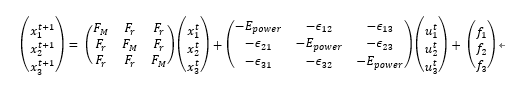

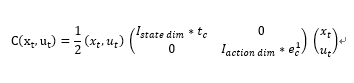

### coefficent

$F_M $ : 기존 구역의 temperature가 유지(Maintain)되는 정도

$F_r $ : 구역에서 다른 구역으로 temperature가 방출(Release)되는 비율

$E_power $: 에어컨 성능(Power)의 정도

$f_i $: i번째 구역에 외부로 부터 들어오는 열의 정도

$I $: 항등행렬, 밑의 첨자는 항등행렬의 크기

$t_c $: 현재 temperature에 대한 페널티 크기

$e^{1}_{c},$ : 사용한 에너지에 대한 페널티 크기

$ \epsilon_{ij} $: i구역의 에어컨 제어가 j 구역에 미치는 영향 정도(random term)

로 생각하시면 됩니다.

### setting coefficient

In [251]:
import random

# number of sector and airconditioner
state_dim = 3
action_dim = 3
T = 20
total_dim = state_dim + action_dim

# matrix shape [(state_dim + action_dim) * (state_dim + action_dim)]
C = torch.eye(n=state_dim + action_dim)

# set t_c and e_c
C[:state_dim, :state_dim] = C[:state_dim, :state_dim] * 10
C[state_dim:, state_dim:] = C[state_dim:, state_dim:] * 5


# matrix shape [(state_dim + action_dim), 1)]
c = torch.zeros(size=(total_dim, 1))

# matrix shape [state_dim * (state_dim + action_dim)]
# set F_M, F_r, E_power, epsilon_ij
F = torch.zeros(size=(state_dim, total_dim))
for i in range(state_dim):
    for j in range(state_dim):
        if i != j:
            F[i, j] = random.uniform(0, 1) / 10
        else:
            F[i, i] = 0.9
for i in range(state_dim):
    for j in range(action_dim):
        if i != j:
            F[i, state_dim + j] = - random.uniform(0, 1) / 10
        else:
            F[j, state_dim + j] = - random.uniform(0.5, 1)
            
# matrix shape[(state_dim, 1)]
# set f_i
f = torch.rand(size=(state_dim, 1))

### initial temperature

In [254]:
x0 = torch.ones(size=(state_dim, 1)) * 50

### check invertible

In [252]:
torch.matrix_rank(C) == total_dim

tensor(True)

# 직접 구현

### def calculate_Q

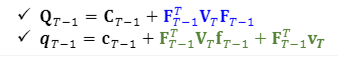

In [5]:
def calculate_Q(C, c, F, f, V_t, v_t, state_dim, action_dim):

    """
    C : torch.tensor() with shape(state_dim + action_dim, state_dim + action_dim)
    c : torch.tensor() with shape(state_dim + action_dim, 1)
    F : torch.tensor() with shape(state_dim, state_dim + action_dim)
    f : torch.tensor() with shape(state_dim, 1)
    V : torch.tensor() with shape(state_dim, state_dim)
    v : torch.tensor() with shape(state_dim, 1)
    """

    
    """
    Q : torch.tensor() with shape(state_dim + action_dim, state_dim + action_dim)
    q: torch.tensor() with shape(state_dim + action_dim, 1)
    """
    
    return Q_t, q_t

### def calculate_V
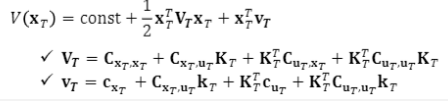

In [6]:
def calculate_V(C, c, K_t, k_t, state_dim, action_dim):
    
    """
    C : torch.tensor() with shape(state_dim + action_dim, state_dim + action_dim)
    c : torch.tensor() with shape(state_dim + action_dim, 1)
    K : torch.tensor() with shape(action_dim, state_dim)
    k : torch.tensor() with shape(action_dim, 1)
    """
    
    
    """
    V : torch.tensor() with shape(state_dim, state_dim)
    v : torch.tensor() with shape(state_dim, 1)
    """
    return V_t, v_t

### def calculate_K
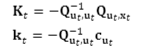

In [3]:
def calculate_K(Q, q, state_dim, action_dim):
    """
    Q : torch.tensor() with shape(state_dim + action_dim, state_dim + action_dim)
    q : torch.tensor() with shape(state_dim + action_dim, 1)
    """

    
    
    
    """
    K : torch.tensor() with shape(action_dim, state_dim)
    k : torch.tensor() with shape(action_dim, 1)
    """
    
    return K_t, k_t

### backward recursion
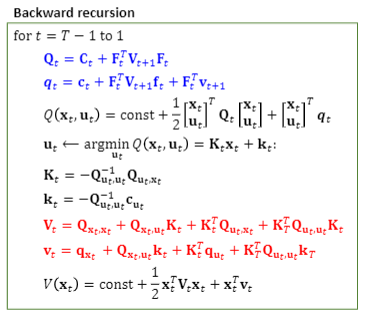

In [4]:
def backward_recursion(state_dim, action_dim, C, c, F, f, T):
    """
    C : torch.tensor() with shape(state_dim + action_dim, state_dim + action_dim)
    c : torch.tensor() with shape(state_dim + action_dim, 1)
    F : torch.tensor() with shape(state_dim, state_dim + action_dim)
    f : torch.tensor() with shape(state_dim, 1)
    """
    
    # dictionary of K
    Large_K = dict()
    small_k = dict()

    # dictionary of V
    Large_V = dict()
    small_v = dict()

    # dictionary of Q
    Large_Q = dict()
    small_q = dict()
    
    
    """
    calculate K, k, V, v at time T and save result at dictionary mentioned above
    by using function calcualte V, K
    """
    
    
    
    
    
    
    
    """
    calculate Q, q, K, k, V, v,at time T-1 to 1 and save result at dictionary mentioned above with for loop
    by using function calcualte V, K, Q
    """

        
        
        
        
        
        
    return Large_Q, small_q, Large_K, small_k, Large_V, small_v

### def forward_recursion
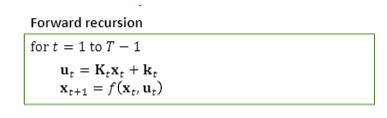

In [7]:
def forward_recursion(x0, Large_K, small_k, F, f, T):
    
    """
    F : torch.tensor() with shape(state_dim, state_dim + action_dim)
    f : torch.tensor() with shape(state_dim, 1)
    K : torch.tensor() with shape(action_dim, state_dim)
    k : torch.tensor() with shape(action_dim, 1)
    """
    
    x_dict = dict()
    u_dict = dict()
    
    x_dict[1] = x0
    
    """
    calculate x, u at time 1 to T-1 and save result at dictionary mentioned above with for loop
    """

        
    return x_dict, u_dict

In [8]:
Large_Q, small_q, Large_K, small_k, Large_V, small_v = backward_recursion(state_dim, action_dim, C, c, F, f, T)

NameError: name 'state_dim' is not defined

In [255]:
x_dict, u_dict = forward_recursion(x0, Large_K, small_k, F, f, T)

### print and plot temperature and energy trajectory

In [256]:
xs = dict()
for state in range(state_dim):
    xs[state] = []
us = dict()
for action in range(action_dim):
    us[action] = []
    
for key, item in x_dict.items():
    for state in range(state_dim):
        xs[state].append(float(item[state]))

for key, item in u_dict.items():
    for action in range(action_dim):
        us[action].append(float(item[action]))

Text(0.5, 1.0, 'Temperature')

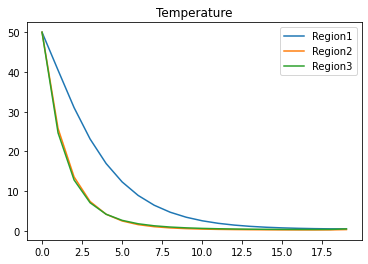

In [257]:
for state in range(state_dim):
    plt.plot(xs[state])

plt.legend(["Region" + str(i+1) for i in range(state_dim)])
plt.title("Temperature")

In [258]:
plt.clf()

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Energy')

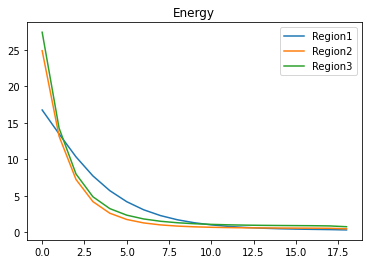

In [259]:
for action in range(action_dim):
    plt.plot(us[action])

plt.legend(["Region" + str(i+1) for i in range(action_dim)])
plt.title("Energy")